# <center> Практика. Статистические тесты в контексте EDA

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Необходимо  исследовать данные и сделайть выводы по полученным результатам. Подкрепить рассуждения и выводы визуализациями и с помощью статистического тестирования, проверить, являются ли выводы статистически значимыми. 
В процессе анализа выяснить:

1. Какие факторы влияют на зарплату специалиста Data Scientist.
2. Ответить на ключевые вопросы HR-агентства:
    * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?



На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

## Загрузка данных

In [3]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [4]:
# необходимо скачать датасет ds_salaries.csv в папку data. Ссылка на файл https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries
data = pd.read_csv('data/ds_salaries.csv', sep=',', index_col=0)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [5]:

# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [7]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


### Факторы, влияющие на зарплату специалиста Data Scientist.

Создадим новый столбец  Position (должность) на основании столбца job_title. Для этого проанализируем значения представленные в столбце job_title. Выделим из них ТОП- 5.

In [8]:
print(data['job_title'].value_counts())

job_title
Data Scientist                              130
Data Engineer                               121
Data Analyst                                 82
Machine Learning Engineer                    39
Research Scientist                           16
Data Science Manager                         12
Data Architect                               11
Big Data Engineer                             8
Machine Learning Scientist                    8
Principal Data Scientist                      7
AI Scientist                                  7
Data Science Consultant                       7
Director of Data Science                      7
Data Analytics Manager                        7
ML Engineer                                   6
Computer Vision Engineer                      6
BI Data Analyst                               6
Lead Data Engineer                            6
Data Engineering Manager                      5
Business Data Analyst                         5
Head of Data                  

In [9]:
data['position'] = data['job_title'].map({'Data Scientist': 'DS', 'Data Engineer': 'DE', 'Data Analyst' : 'DA', 'Machine Learning Engineer' : 'MLE' })
data['position'].replace(
    to_replace=[None],
    value='Other',
    inplace=True
)
print(data['position'].value_counts())
display(data)

position
Other    193
DS       130
DE       121
DA        82
MLE       39
Name: count, dtype: int64


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,position
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L,DS
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S,Other
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M,Other
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S,Other
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L,MLE
...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M,DE
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M,DE
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M,DA
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M,DA


#### Рассмотрим взаимосвязь между опытом работы и уровнем зарплаты.

In [ ]:
group_exp_lev = data.groupby('experience_level', as_index=False)['salary_in_usd'].median()
fig_1 = px.bar(
    data_frame=group_exp_lev,
    x='salary_in_usd',
    y='experience_level',
    height=500, 
    width=700, 
    title='Зависимость медианной заработной платы от опыта работы'
)
fig_1.show()

![](images/newplot.png)

Как видим из графика, ожидаемо, самый высокий уровень зарплат у специалистов уровня Executive-level/Director.

#### Посмотрим взаимосвязь зп и резидентства сотрудников:

In [11]:
# узнаем количество стран резидентов
data['employee_residence'].nunique(0)

57

In [12]:
# количество представленных вакансий по странам резидентам
data['employee_residence'].value_counts()

employee_residence
US    295
GB     43
IN     30
CA     27
DE     24
FR     18
ES     15
GR     12
JP      7
PT      6
BR      6
PK      6
NL      5
PL      4
IT      4
RU      4
AE      3
AT      3
VN      3
TR      3
AU      3
RO      2
BE      2
SG      2
SI      2
DK      2
HU      2
NG      2
MX      2
BO      1
MY      1
TN      1
IE      1
DZ      1
AR      1
CZ      1
JE      1
LU      1
PR      1
RS      1
EE      1
CL      1
HK      1
KE      1
MD      1
CO      1
IR      1
CN      1
MT      1
UA      1
IQ      1
HN      1
BG      1
HR      1
PH      1
NZ      1
CH      1
Name: count, dtype: int64

Построим график зависимости зп для резидентов

In [ ]:
group_emp_res = data.groupby('employee_residence', as_index=False)['salary_in_usd'].median()
fig_2 = px.bar(
    data_frame=group_emp_res,
    x='salary_in_usd',
    y='employee_residence',
    barmode='group',
    height=500, 
    width=700, 
    title='Зависимость медианной заработной платы от резидентства'
)
fig_2.show()

![](images/fig_2.png)

Из графика можем увидеть, что самая высокая зп в Малайзии, на втором месте Пуэрто Рико, 3 место - США, 4 - Новая Зеландия, 5 - Чехия.
Следует заметить, что в пятерке стран все кроме США представлены по 1 позиции вакансии,  что может говорить о диффиците кадров в области DS конкретно для данной страны.

In [14]:
data[data['employee_residence'] == 'NZ'].value_counts()

work_year  experience_level  employment_type  job_title           salary  salary_currency  salary_in_usd  employee_residence  remote_ratio  company_location  company_size  position
2020       SE                FT               Lead Data Engineer  125000  USD              125000         NZ                  50            NZ                S             Other       1
Name: count, dtype: int64

#### Рассмотрим зависимость зарплаты от типа трудоустройства. 

In [ ]:
group_emp_type = data.groupby('employment_type', as_index=False)['salary_in_usd'].median()
fig_3 = px.bar(
    data_frame=group_emp_type,
    x='salary_in_usd',
    y='employment_type',
    height=500, 
    width=700, 
    title='Зависимость медианной заработной платы от типа трудоустройства'
)
fig_3.show()

![](images/fig_3.png)

Из графика видим, что самый высокий уровень зп для оформления занятости по контракту.

### Распределение распределение заработной платы (в USD) по отрасли DS

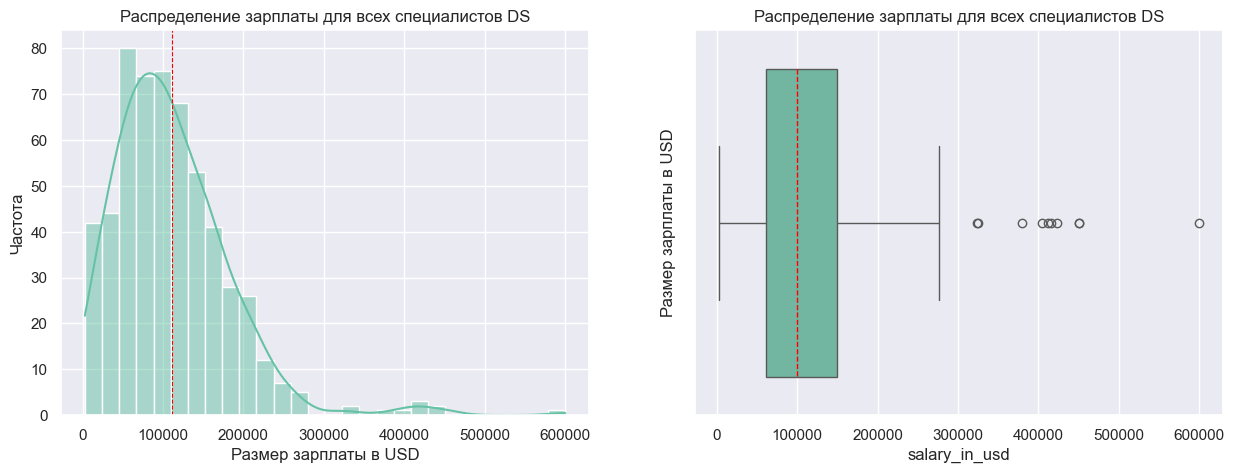

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплаты в USD', ylabel='Частота')
axes[0].set_title('Распределение зарплаты для всех специалистов DS')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер зарплаты в USD')
axes[1].set_title('Распределение зарплаты для всех специалистов DS')

plt.show()

Из графиков видим, что распределение отлично от нормального, большинство наблюдений сосредоточены между значений от 80000 до 150000 долл., до 80000 и после 150000 частота падает, что говорит нам о том, что меньшая часть специалистов имеет з/п ниже или выше указанных цифр. Среднее значение з/п чуть выше 100000 долл. (Вероятнее всего рассматривается з/п за год). Медиана составляет 100000 долл., что не совпадает со средним значением и подтверждает утверждение, что распределение не является нормальным.

In [17]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплаты в USD']
data_agg

,Размер зарплаты в USD
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


Вывод: Распределение заработной платы отлично от нормального, имеются выбросы.

### Заработная плата в зависимости от года

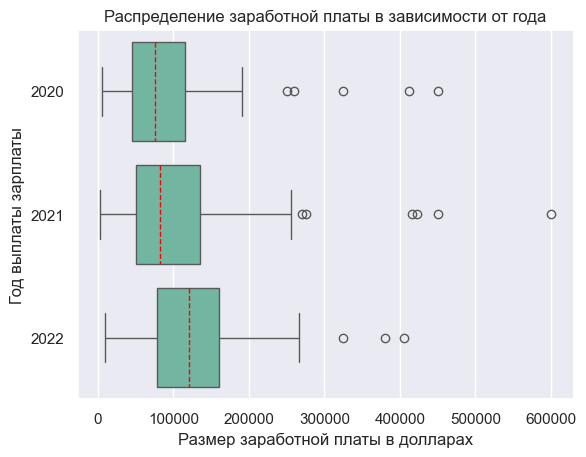

In [18]:
ax = sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер заработной платы в долларах', ylabel='Год выплаты зарплаты')
plt.title('Распределение заработной платы в зависимости от года')
plt.show()

Из построенного графика видим, наблюдается тенденция к росту медианы заработной платы по годам. В 2020 году медиана около 80000 долл, в 2021 - 90000, в 2022 - свыше 100000 (примерно 120000). Говоря о межквартильных размахах можем сделать предположение, что в целом наблюдается тенденция к увеличению уровня заработной платы (как минимальных, так и максимальных значеий).

In [19]:
data_agg = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Распределение заработной платы в зависимости от года')
data_agg

Распределение заработной платы в зависимости от года


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,215.0,99430.41,80304.32,2859.0,50000.0,82528.0,135000.0,600000.0
2022,278.0,123089.10,59888.93,10000.0,78791.0,120000.0,160000.0,405000.0


Количество специалистов с каждым годом растет. Распределения заработной платы в зависимости от года различны, отличны от нормального.  Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование. 

Сводная таблица медианных значений зарплате по годам в разрезе должностей
                   mean                                               \
position             DA             DE             DS            MLE   
work_year                                                              
2020       45547.285714   88162.000000   85970.523810  125389.800000   
2021       79505.411765   79434.870968   70215.772727   74611.222222   
2022       98567.655172  124651.784810  131366.938462  123468.062500   

                            median                                          
position           Other        DA        DE        DS       MLE     Other  
work_year                                                                   
2020       113485.464286   46759.0   74130.0   62726.0  138000.0   99000.0  
2021       125056.857143   75000.0   76833.0   67233.5   70132.5  102839.0  
2022       135666.900000  105630.0  115000.0  135000.0  120000.0  140570.5  


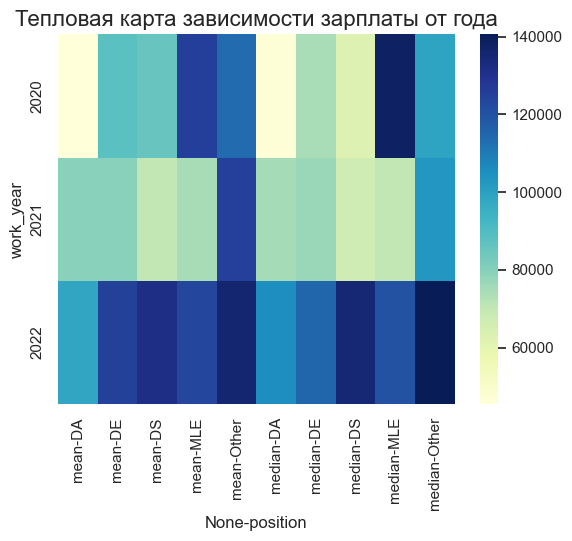

In [20]:
grouped_by_position_work_year = data.pivot_table(
    values='salary_in_usd',
    index='work_year',
    columns='position',
    aggfunc={'median', 'mean'}
)
print('Сводная таблица медианных значений зарплате по годам в разрезе должностей')
print(grouped_by_position_work_year)
heatmap = sns.heatmap(data=grouped_by_position_work_year, cmap='YlGnBu')
heatmap.set_title('Тепловая карта зависимости зарплаты от года', fontsize=16);

Из построенного графика видим, наблюдается тенденция к росту медианы заработной платы по годам у специалистов DS. Вцелом по выборке наблюдается тенденция к росту з/п в направлении Big Data, о чем нам говорила ранее коробчатая диаграмма. И еще раз убеждаемся в том, что распределения заработной платы для DS отличны от нормального.

### Соотношение зарплаты Data Scientist и Data Engineer в 2022 году

Создадим выборку на основании исходной, удовлетворяющей запросу задачи.

In [21]:
options = ['DS' ,'DE'] 
rslt_df_1 = data[(data['work_year'] == 2022) & 
          data['position'].isin(options)] 
#display(rslt_df)

Text(0.5, 1.0, 'Зависимость средней зарплаты DS и DE в 2022')

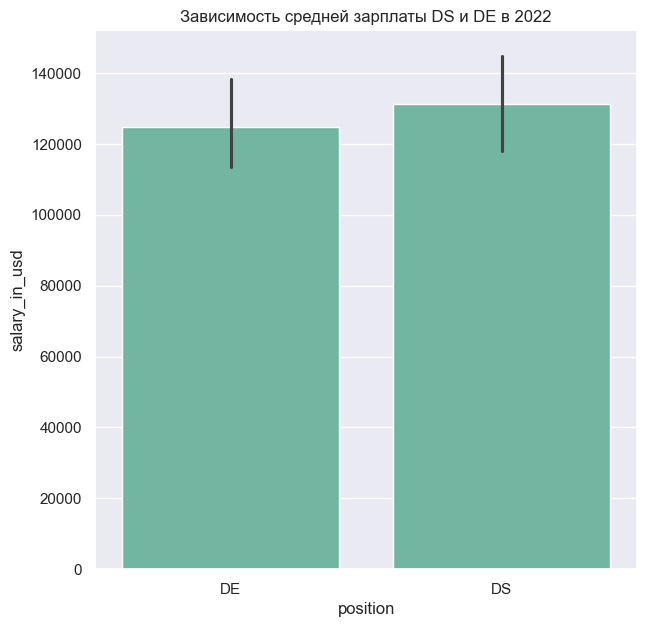

In [22]:
fig_4 = plt.figure(figsize=(7, 7))
barplot = sns.barplot(
    data=rslt_df_1,
    x='position',
    y='salary_in_usd',
)
barplot.set_title('Зависимость средней зарплаты DS и DE в 2022')

In [23]:
data_agg = rslt_df_1.groupby('position')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от должности')
data_agg

Зарплата в зависимости от должности


,count,mean,std,min,25%,50%,75%,max
position,,,,,,,,
DE,79.0,124651.78,57846.84,25000.0,78526.0,115000.0,160040.0,324000.0
DS,65.0,131366.94,55785.24,18442.0,95550.0,135000.0,170000.0,260000.0


Из проделанного анализа видим, что в 2022 году уровень заработной платы DE незначительно меньше уровня з/п DS.

### Соотношение зарплаты Data Scientist в компаниях различных размеров

Text(0.5, 1.0, 'Соотношение зарплаты Data Scientist в компаниях различных размеров')

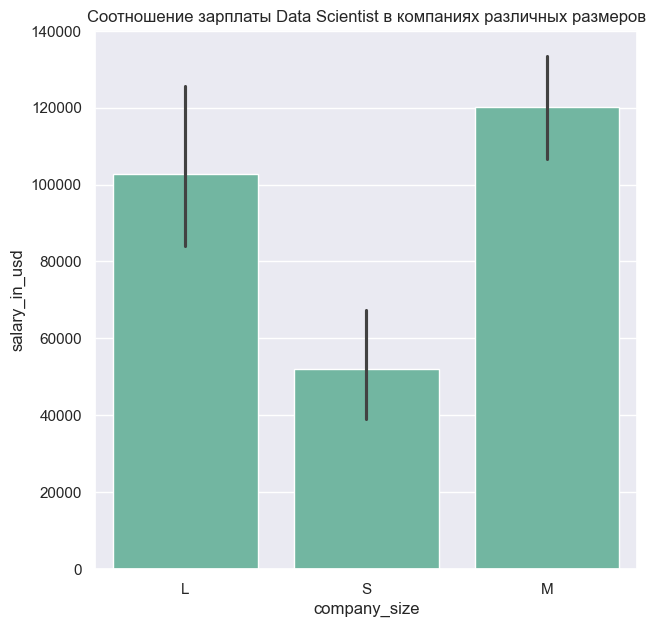

In [24]:
rslt_df_2 = data[data['position'] == 'DS'] 
#display(rslt_df)

fig_5 = plt.figure(figsize=(7, 7))
barplot = sns.barplot(
    data=rslt_df_2,
    x='company_size',
    y='salary_in_usd',
)
barplot.set_title('Соотношение зарплаты Data Scientist в компаниях различных размеров')

In [25]:
data_agg = rslt_df_2.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от должности')
data_agg

Зарплата в зависимости от должности


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,43.0,102743.42,73254.10,13400.0,45240.5,90734.0,135000.0,412000.0
M,66.0,120080.58,56347.79,4000.0,80000.0,119529.5,157500.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


Как можно заметить, самые высокие зарплаты предлагают компании среднего размера (М), ниже уровень з/п в больших компаниях, и самый низкий уровень в малениких компаниях (S). Можно предположить, что компании среднего размера заинтересованы в развитии бизнеса, в следствие чего и готовы привлекать специалистов DS. 

### Взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании

In [26]:
options = ['DS' ,'DE'] 
rslt_df_3 = data[data['position'].isin(options)] 
group_rslt_df_3 = rslt_df_3.groupby(
    ['position', 'company_size'], 
    as_index=False
)['salary_in_usd'].median()
display(group_rslt_df_3)


,position,company_size,salary_in_usd
0,DE,L,93141.0
1,DE,M,110500.0
2,DE,S,65511.0
3,DS,L,90734.0
4,DS,M,119529.5
5,DS,S,49268.0


In [ ]:
fig_6 = px.bar(
    data_frame=group_rslt_df_3,
    x='salary_in_usd',
    y='company_size',
    color='position',
    barmode='group',
    title='Зависимость медианной з/п между наличием должностей Data Scientist и Data Engineer и размером компании' 
)
fig_6.show()

![](images/fig_6.png)

In [28]:
pd.pivot_table(rslt_df_3,
               index=["company_size", "position"],
               values=["salary_in_usd"],
               aggfunc=[np.count_nonzero, np.mean, np.median, np.min, np.max])

C:\Users\mtsul\AppData\Local\Temp\ipykernel_20196\2756167386.py:1: FutureWarning:

The provided callable <function mean at 0x000001D0259B1EE0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

C:\Users\mtsul\AppData\Local\Temp\ipykernel_20196\2756167386.py:1: FutureWarning:

The provided callable <function median at 0x000001D025AAC2C0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.

C:\Users\mtsul\AppData\Local\Temp\ipykernel_20196\2756167386.py:1: FutureWarning:

The provided callable <function min at 0x000001D0259B1620> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.

C:\Users\mtsul\AppData\Local\Temp\ipyker

count_nonzero           mean        median  \
                      salary_in_usd  salary_in_usd salary_in_usd   
company_size position                                              
L            DE                  34   96875.617647       93141.0   
             DS                  43  102743.418605       90734.0   
M            DE                  81  118369.481481      110500.0   
             DS                  66  120080.575758      119529.5   
S            DE                   6   66342.500000       65511.0   
             DS                  21   51925.761905       49268.0   

                                min           max  
                      salary_in_usd salary_in_usd  
company_size position                              
L            DE               20000        209100  
             DS               13400        412000  
M            DE                4000        324000  
             DS                4000        260000  
S            DE               33511        115000  
             DS                2859        105000

Из графика и сводных данных в группировке по размеру компании и должности (DS, DE) видим, что самые высокие заплаты у DS в компаниях среднего размера.Чуть ниже у DE в этих же компаниях. Хотя компании размера S и L готовы платить больше DE по сравнению с DS. Вероятнее всего, это происходит по причине того, что компании среднего размера заинтересованы в развитии бизнеса, в связи с чем есть необходимость в проверке гипотез, построении прогнозных моделей и решении бизнес-задач. Для компаний размеров S и L большую необходимость имеют DE в связи с разработкой, построения, тестировки и поддержки архитектуры данных, а так же подготовки данных для использования DS, которые, возможно, работают на аутсорсе.

## Статистический анализ данных

In [29]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

### Размер заработной платы специалиста Data Scientist в последущий год выше, чем заработная плата специалиста Data Scientist в предыдущий год?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): заработные платы в 2020 ($μ_1$), 2021 ($μ_2$) и 2022 ($μ_3$) статистически меньше либо равны.

$$ H_0 : μ_1 <= μ_2 <= μ_3$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы 2020 ($μ_1$) статистически больше, чем размер зп в 2021 ($μ_2$), и 2022 ($μ_3$).

$$ H_1 : μ_1 > μ_2 > μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [30]:
data_ds = data[data['position'] == 'DS']


In [31]:
# значения зарплат
salary_in_usd_2020 = data_ds.loc[data['work_year']== 2020, 'salary_in_usd']
salary_in_usd_2021 = data_ds.loc[data['work_year']== 2021, 'salary_in_usd']
salary_in_usd_2022 = data_ds.loc[data['work_year']== 2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(salary_in_usd_2020)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(salary_in_usd_2021)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(salary_in_usd_2022)
decision_normality(result[1])

Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет, да, да.

Чтобы проверить нашу гипотезу, будем использовать критерий Краскела - Уоллеса для сравнения распределений на основе рангов. (при сравнии выборок где  хотябы одна из них "ненормальная", применяем непараметральный тест).

**Проведём тест**

In [32]:
# проводим тест
_, p = stats.kruskal(salary_in_usd_2020, salary_in_usd_2021, salary_in_usd_2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Заработные платы специалистов DS увеличиваются с каждым годом.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): в 2022 году размер зарплат DE ($μ_1$) статистически равны зарплатам DS ($μ_2$).

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): в 2022 году размер зарплат DE ($μ_1$) статистически не равны зарплате DS ($μ_2$).
$$ H_1 : μ_1 != μ_2$$


**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [71]:
# значения зарплат
salary_in_usd_ds = rslt_df_1.loc[rslt_df_1['position']=='DS', 'salary_in_usd']
salary_in_usd_de = rslt_df_1.loc[rslt_df_1['position']=='DE', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для DS:')
result = stats.shapiro(salary_in_usd_ds)
decision_normality(result[1])

print('Для DE:')
result = stats.shapiro(salary_in_usd_de)
decision_normality(result[1])

Для DS:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для DE:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплат»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да, нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [76]:
# проводим тест
_, p = stats.mannwhitneyu(salary_in_usd_ds, salary_in_usd_de)
decision_hypothesis(p)

p-value = 0.319
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Для правильности выводов построим график для определения выбросов по позициям DS и DE.

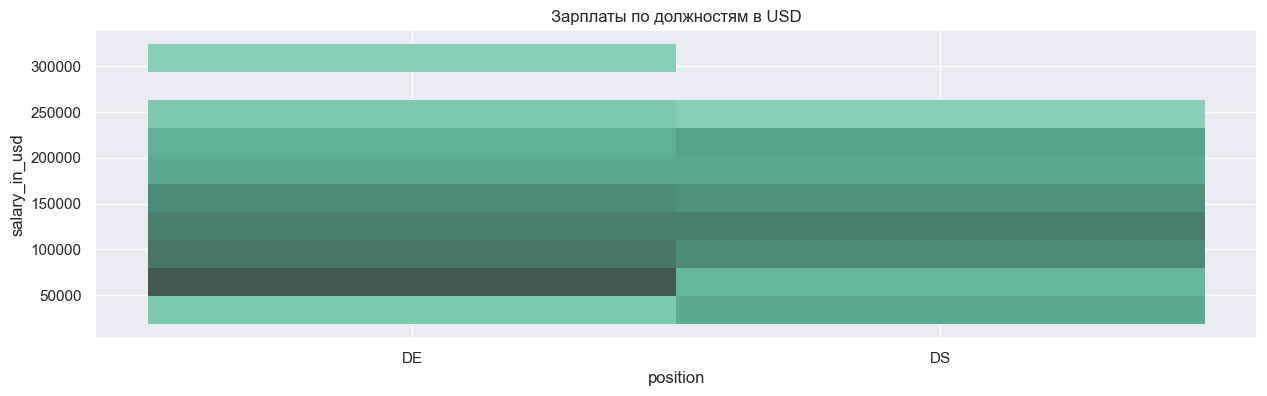

In [73]:
# МЕТОД МЕЖКВАРТИЛЬНОГО РАЗМАХА (МЕТОД ТЬЮКИ)

# Построим гистограмму для признака должность (position):

fig, axes = plt.subplots(nrows=1, figsize=(15, 4))
histplot = sns.histplot(data=rslt_df_1, x='position', y='salary_in_usd');
histplot.set_title('Зарплаты по должностям в USD');


Из графика видим, что для позции и DE присутствуют выбросы.

In [77]:
# Сравним медианы для DS и DE

data_de = rslt_df_1[rslt_df_1['position'] == 'DE']
print('Медиана для DS')
print(data_ds['salary_in_usd'].median())
print('Медиана для DE')
print(data_de['salary_in_usd'].median())

Медиана для DS
100000.0
Медиана для DE
115000.0


**Вывод**

Cтатистический тест не дает нам оснований отвергнуть гипотезу о равенстве зарплат между DS и DE в 2022 году. Медианы незначительно отличаются, таким образом, на основании стат.теста, графика межквартильного размаха и сравнения медиан сделаем вывод о том, что зарплаты DS и DE в 2022 году статистически равны.

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): заработные платы DS в компаниях S, M и L ($μ_1$), ($μ_2$) и ($μ_3$) статистически меньше либо равны.

$$ H_0 : μ_1 <= μ_2 <= μ_3$$

*Альтернативная гипотеза* ($H_1$): заработные платы DS в компаниях S, M и L ($μ_1$), ($μ_2$) и ($μ_3$) статистически больше.
$$ H_1 : μ_1 > μ_2 > μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [78]:
# значения зарплат
salary_in_usd_S = data_ds.loc[data['company_size']== 'S', 'salary_in_usd']
salary_in_usd_M = data_ds.loc[data['company_size']== 'M', 'salary_in_usd']
salary_in_usd_L = data_ds.loc[data['company_size']== 'L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для S:')
result = stats.shapiro(salary_in_usd_S)
decision_normality(result[1])

print('Для M:')
result = stats.shapiro(salary_in_usd_M)
decision_normality(result[1])

print('Для L:')
result = stats.shapiro(salary_in_usd_L)
decision_normality(result[1])

Для S:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для M:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да, да, нет.

Чтобы проверить нашу гипотезу, будем использовать критерий Краскела - Уоллеса для сравнения распределений на основе рангов. (при сравнии выборок где  хотябы одна из них "ненормальная", применяем непараметральный тест).

**Проведём тест**

In [79]:
# проводим тест
_, p = stats.kruskal(salary_in_usd_S, salary_in_usd_M, salary_in_usd_L)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Зарплаты специалистов DS в компаниях бОльшего размера статистически больше. 

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): между размером компании, и наличием должностей DS и DE нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза* ($H_1$): между размером компании, и наличием должностей DS и DE есть взаимосвязь (признаки зависимы)

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака должность? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [85]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(rslt_df_3['company_size'], rslt_df_3['position'])
cross_table

position,DE,DS
company_size,,
L,34,43
M,81,66
S,6,21


In [86]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между размером компании и наличием в ней должностей DS и  DE.

## Итоговые результаты исследования

*   Заработные платы Data Scientist растут с каждым годом.
*   Соотношение зарплаты Data Scientist и Data Engineer в 2022 году примерно одинаково.
*   Уровень заработной платы Data Scientist зависит от размера компании.
*   Существует взаимосвязь между размером компании и наличием в ней должностей Data Scientist и  Data Engineer.

## Анализ влияния типа занятости на зарплату специалистов

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Уровни заработной платы у полностьью занятых (FT) ($μ_1$), работающих неполный день (PT)($μ_2$), контрактников (CT)($μ_3$) и фрилансеров (FL) ($μ_4$) одинаковы.

$$ H_0 : μ_1 = μ_2 = μ_3= μ_4$$

*Альтернативная гипотеза* ($H_1$):Уровни заработной платы у полностьью занятых (FT) ($μ_1$), работающих неполный день (PT)($μ_2$), контрактников (CT)($μ_3$) и фрилансеров (FL) ($μ_4$) неодинаковы .

$$ H_1 : μ_1 \neq μ_2 \neq μ_3\neq μ_4$$


**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [89]:
# значения заработной платы 
salary_in_USD_FT = data.loc[data['employment_type']=='FT', 'salary_in_usd']
salary_in_USD_PT = data.loc[data['employment_type']=='PT', 'salary_in_usd']
salary_in_USD_CT = data.loc[data['employment_type']=='CT', 'salary_in_usd']
salary_in_USD_FL = data.loc[data['employment_type']=='FL', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для FT:')
result = stats.shapiro(salary_in_USD_FT)
decision_normality(result[1])

print('Для PT:')
result = stats.shapiro(salary_in_USD_PT)
decision_normality(result[1])

print('Для CT:')
result = stats.shapiro(salary_in_USD_CT)
decision_normality(result[1])

print('Для FL:')
result = stats.shapiro(salary_in_USD_FL)
decision_normality(result[1])

Для FT:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для PT:
p-value = 0.023
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для CT:
p-value = 0.406
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для FL:
p-value = 0.507
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать Краскела — Уоллеса.

**Проведём тест**

In [90]:
# проводим тест
_, p = stats.kruskal(salary_in_USD_FT, salary_in_USD_PT, salary_in_USD_CT, salary_in_USD_FL)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Уровень заработной платы зависит от типа занятости специалистов.

## Анализ влияния объема удаленной работы на зарплату специалистов DS

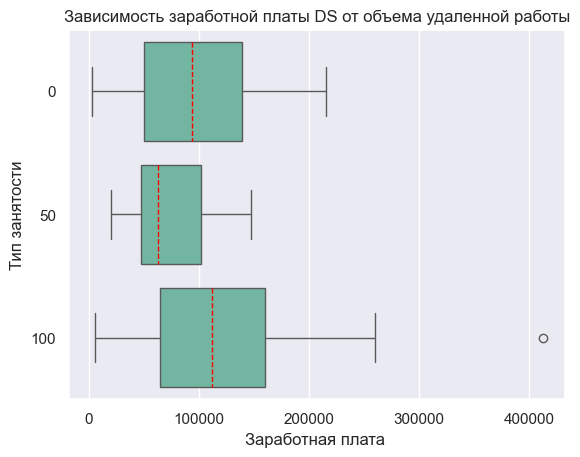

In [91]:
#Рассматриваем влияние объема удаленной работы на размер заработной платы 
ax = sns.boxplot(data_ds, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Заработная плата ', ylabel='Тип занятости')
plt.title('Зависимость заработной платы DS от объема удаленной работы')
plt.show()

Как видно из гистограммы, удаленная работа влияет на зп DS. При чем у сотрудников на полной удаленке медиана зп выше чем у всех остальных.

### Влияет ли объем удаленной работы на размер заработной платы специалистов ?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Уровни заработной платы у специалистов, у которых удалённой работы нет (менее 20 %)(0)($μ_1$), у специалистов, работающих частично удалённо(50), у специалистов, полностью работающих удалённо (более 80 %)(100)($μ_3$) одинаковы.

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$):Уровни заработной платы у специалистов, у которых удалённой работы нет (менее 20 %)(0)($μ_1$), у специалистов, работающих частично удалённо(50)($μ_2$), у специалистов, полностью работающих удалённо (более 80 %)(100)($μ_3$) неодинаковы.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [92]:
# значения заработной платы 
salary_0 = data_ds.loc[data_ds['remote_ratio']==0, 'salary_in_usd']
salary_50 = data_ds.loc[data_ds['remote_ratio']==50, 'salary_in_usd']
salary_100 = data_ds.loc[data_ds['remote_ratio']==100, 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для ZR:')
result = stats.shapiro(salary_0)
decision_normality(result[1])

print('Для HF:')
result = stats.shapiro(salary_50)
decision_normality(result[1])

print('Для FL:')
result = stats.shapiro(salary_100)
decision_normality(result[1])


Для ZR:
p-value = 0.331
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для HF:
p-value = 0.387
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для FL:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать Краскела — Уоллеса.

**Проведём тест**

In [93]:
# проводим тест
_, p = stats.kruskal(salary_0, salary_50, salary_100)
decision_hypothesis(p)

p-value = 0.020
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Уровень заработной платы зависит от объема удаленной работы.

# Итоговые результаты дополнительных исследований

*   Уровень заработной платы зависит от типа занятости специалистов по всей выборке.
*   Уровень заработной платы специалистов Data Science зависит от объема удаленной работы.